In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 

warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

python 3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]
keras version 2.3.1
tensorflow version 2.1.0


Using TensorFlow backend.


In [2]:
## The location of the Flickr8K_ images
dir_Flickr_jpg = r"D:\icg\Image-Caption-Generator-master\Images"
## The location of the caption file
dir_Flickr_text = "D:\icg\Image-Caption-Generator-master\Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8091


In [3]:
file = open(dir_Flickr_text,'r', encoding='utf8')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#") # Splitting the caption dataset at the required position
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())
print(df_txt[:5])

The number of unique file names : 8092
The distribution of the number of captions for each image:
                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  


In [4]:
# Defining a function to calculate the top 3 words in all the captions available for the images
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975


In [5]:
import string
text_original = "I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1,printTF=True)
print(text_no_numeric)

I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?

Remove punctuations..
I ate 1000 apples and a banana I have python v27 Its 230 pm Could you buy me iphone7

Remove a single character word..
 ate 1000 apples and banana have python v27 Its 230 pm Could you buy me iphone7

Remove words with numeric values..
    ate        : True
    1000       : False
    apples     : True
    and        : True
    banana     : True
    have       : True
    python     : True
    v27        : False
    Its        : True
    230        : False
    pm         : True
    Could      : True
    you        : True
    buy        : True
    me         : True
    iphone7    : False
 ate apples and banana have python Its pm Could you buy me


In [6]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

In [7]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [8]:
from keras.applications.vgg16 import VGG16

modelvgg = VGG16(include_top=True,weights=None)
## load the locally saved weights 
modelvgg.load_weights(r"D:\icg\Image-Caption-Generator-master\vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()




Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
from keras import models
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)
## show the deep learning model
modelvgg.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [10]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
import numpy as np

images = OrderedDict()
count = 0
npix = 224 #image size is fixed at 224 because VGG16 model has been pre-trained to take that size.
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3),dtype='uint8')
for i,name in enumerate(jpgs):
    # load an image from file
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    count+=1
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

In [11]:
type(images)

collections.OrderedDict

In [13]:

import json
with open('sample.json', 'r') as openfile:
  
    # Reading from json file
    x = json.load(openfile)

In [14]:
image = dict(x)

In [15]:
from sklearn.decomposition import PCA

encoder = np.array(list(images.values()))
#print(encoder)
pca = PCA(n_components=2)
#print(pca)
y_pca = pca.fit_transform(encoder)

In [16]:
dimages, keepindex = [],[]
# Creating a datframe where only first caption is taken for processing
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)

#fnames are the names of the image files        
fnames = df_txt0["filename"].iloc[keepindex].values
#dcaptions are the captions of the images 
dcaptions = df_txt0["caption"].iloc[keepindex].values
#dimages are the actual features of the images
dimages = np.array(dimages)

In [17]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 6000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


In [18]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [19]:
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

30


In [20]:
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages)) # using assert to make sure that length of images and captions are always similar
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        # zip() is used to create a tuple of iteratable items
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()# using pad sequence to make the length of all captions equal
            out_text = to_categorical(out_text,num_classes = vocab_size) # using to_categorical to 

            
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data

# captions/images = 4855
 (49631, 30) (49631, 4096) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 4096) (16353, 4476)


In [21]:
from keras import models

In [22]:
from keras import layers
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU, PReLU
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature",return_sequences=True)(ftxt)
#,return_sequences=True
#,activation='relu'
se2 = Dropout(0.04)(ftxt)
ftxt = layers.LSTM(256,name="CaptionFeature2")(se2)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

4476
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 64)       286464      input_3[0][0]                    
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 30, 256)      328704      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 30, 256)      0           CaptionFeature[0][0]             
_______________________________________________________________________________________

In [24]:
# fit model
from time import time
from keras import Model
from keras.models import load_model
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=6, verbose=2, 
                  batch_size=32,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
#model.save("main23.h5")

Train on 49631 samples, validate on 16353 samples
Epoch 1/6
 - 492s - loss: 4.9677 - val_loss: 4.7543
Epoch 2/6
 - 482s - loss: 4.3347 - val_loss: 4.6216
Epoch 3/6
 - 481s - loss: 3.9916 - val_loss: 4.5170
Epoch 4/6
 - 484s - loss: 3.7488 - val_loss: 4.6088
Epoch 5/6
 - 504s - loss: 3.5490 - val_loss: 4.6530
Epoch 6/6
 - 498s - loss: 3.3742 - val_loss: 4.7893


In [25]:
from keras.models import load_model
loaded_model = load_model("main.h5")
#loss, accuracy = loaded_model.evaluate(test_data, test_targets)


[1.4410406 0.2829219 0.        ... 0.        2.4592    0.       ]
1
D:\icg\Image-Caption-Generator-master\Images/1015118661_980735411b.jpg
2
<PIL.Image.Image image mode=RGB size=224x224 at 0x1BA0C9816A0>
3
startseq man in blue shirt is standing on the street endseq
[0.7002899 0.        1.256156  ... 0.        0.        0.       ]
1
D:\icg\Image-Caption-Generator-master\Images/1015584366_dfcec3c85a.jpg
2
<PIL.Image.Image image mode=RGB size=224x224 at 0x1BA0CA09710>
3
startseq brown and brown dog is running over the grass endseq
[0.        0.        0.7495302 ... 0.        2.2005944 0.5350666]
1
D:\icg\Image-Caption-Generator-master\Images/101654506_8eb26cfb60.jpg
2
<PIL.Image.Image image mode=RGB size=224x224 at 0x1BA0CA21A90>
3
startseq black and white dog is running through the snow endseq
[1.1132046 0.        0.        ... 0.        6.9780636 1.1585555]
1
D:\icg\Image-Caption-Generator-master\Images/101669240_b2d3e7f17b.jpg
2
<PIL.Image.Image image mode=RGB size=224x224 at 0x1BA0CA4

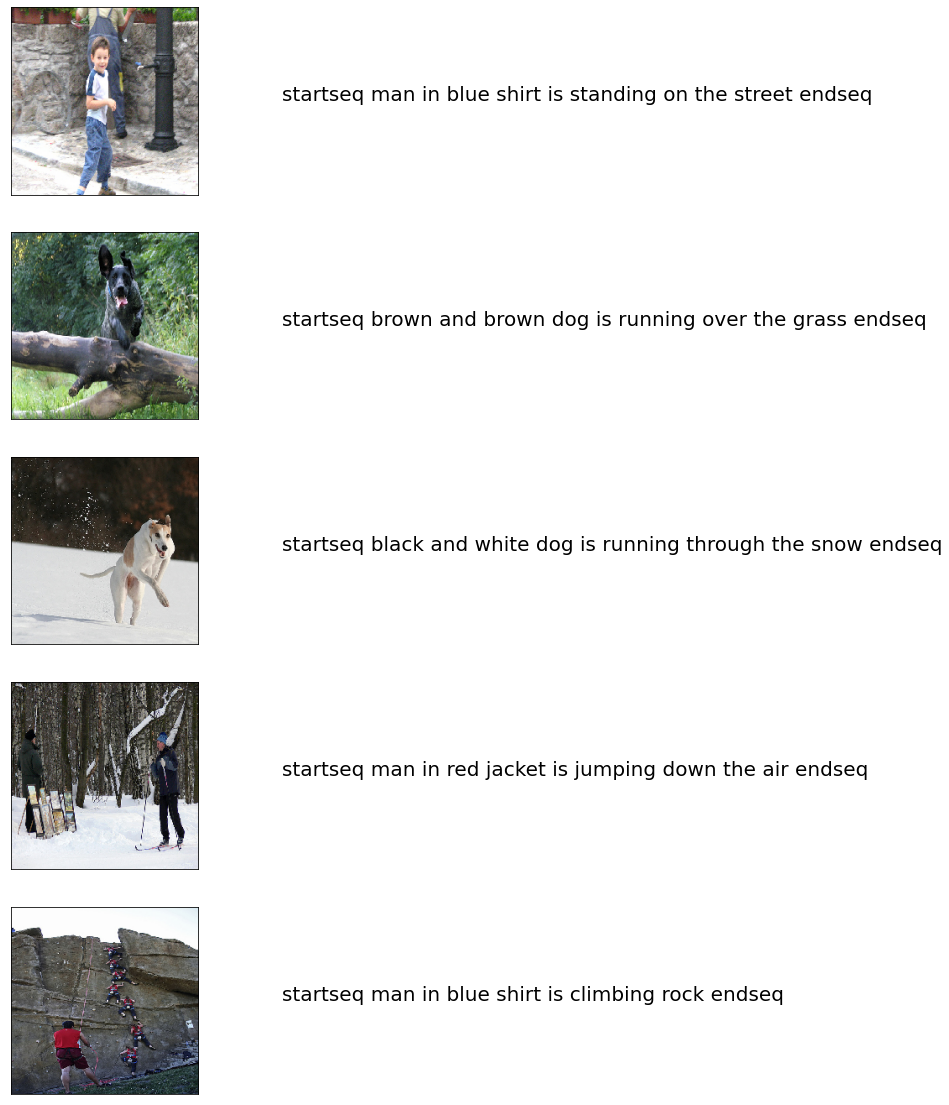

In [26]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = loaded_model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)
#print(target_size)
count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[8:13],di_test[8:13]):
    print(image_feature)
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    print("1")
    print(filename)
    
    image_load = load_img(filename, target_size=target_size)
    print("2")
    print(image_load)
    #print(image_load.shape)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    print("3")
    print(caption)
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [ ]:
#image_feature

# def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)


predict_caption("C:\Users\Hi\Desktop\image caption\\newimg.jpg")





In [27]:
p = di_test[25]


prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [28]:
print(p.reshape(1,len(image_feature)))

[[0.       2.121687 0.       ... 0.       0.       0.      ]]


In [29]:

caption = predict_caption(p.reshape(1,len(image_feature)))
print(caption)

startseq boy in red shirt is playing down the wall endseq


# prediction with new image

In [31]:
filename = r"C:\Users\taart\Downloads\r.jpeg"
image = load_img(filename, target_size=target_size)
# convert the image pixels to a numpy array
image = img_to_array(image)
nimage = preprocess_input(image)

y_pred = loaded_model.predict(nimage.reshape( (1,) + nimage.shape[:3]))
images = y_pred.flatten()
print(len(images))


dimages= images

#fnames are the names of the image files        
fnames = df_txt0["filename"].iloc[keepindex].values
#dcaptions are the captions of the images 
dcaptions = df_txt0["caption"].iloc[keepindex].values
#dimages are the actual features of the images
dimages = np.array(dimages)
print(len(dimages))




ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[[[  23.060997 ,   10.221001 ,   17.32     ],
         [  18.060997 ,   39.221    ,   62.32     ],
         [ -40.939003 ,  -46.779    ,  -36.68     ],
         ...,
         [  -4.939003 ,   ...

In [1]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)
caption = predict_caption(di_test.reshape(1,len(image_feature)))

print(caption)

NameError: name 'dtexts' is not defined

In [ ]:
print(di_test.reshape(1,len(image_feature)))

In [ ]:
print(target_size)

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
filename = r"C:\Users\taart\OneDrive\Desktop\dog.jpg"
image = load_img(filename, target_size=target_size)
# convert the image pixels to a numpy array
image = img_to_array(image)
print(len(image))
nimage = preprocess_input(image)

y_pred = loaded_model.predict(nimage.reshape( (1,) + nimage.shape[:3]))
images = y_pred.flatten()


dimages= images

#fnames are the names of the image files        
fnames = df_txt0["filename"].iloc[keepindex].values
#dcaptions are the captions of the images 
dcaptions = df_txt0["caption"].iloc[keepindex].values
#dimages are the actual features of the images
dimages = np.array(dimages)
print(len(dimages))



# CODE for image caption generator with GUI

In [ ]:
#to browse image
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import tkinter as tk
from tkinter import filedialog
from tkinter.filedialog import askopenfile
from PIL import Image, ImageTk

from gtts import gTTS 

        # import Os module to start the audio file
import os 
    #return audio


from keras.preprocessing import image
import numpy as np
my_w = tk.Tk()
my_w.geometry("700x300")  # Size of the window 
my_w.title('image caption and text to speech generator')
my_font1=('times', 18, 'bold')
l1 = tk.Label(my_w,text='Img caption generator ',width=40,font=my_font1)  
l1.grid(row=1,column=1)
b1 = tk.Button(my_w,bg='green', text='caption', 
   width=20,command = lambda:caption())
b1.grid(row=2,column=1) 

l2 = tk.Label(my_w,text=' text to speech generator ',width=40,font=my_font1)  
l2.grid(row=3,column=1)
b2 = tk.Button(my_w,bg='red', text='speech', 
   width=20,command = lambda:caption())
b2.grid(row=4,column=1) 



def caption():
    global img_name
    import cv2

    cam = cv2.VideoCapture(0)

    cv2.namedWindow("test")

    img_counter = 0

    while True:
        ret, frame = cam.read()
        if not ret:
            print("failed to grab frame")
            break
        cv2.imshow("test", frame)

        k = cv2.waitKey(1)
        if k%256 == 27:
            # ESC pressed
            print("Escape hit, closing...")
            break
        elif k%256 == 32:
            # SPACE pressed
            img_name = "opencv_frame_{}.png".format(img_counter)
            cv2.imwrite(img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1

    cam.release()

    cv2.destroyAllWindows()

    #filename = "C:\\Users\\Hi\\Desktop\\wine\\1.jpg"
    image = load_img(img_name, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)

    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images = y_pred.flatten()


    dimages= images

    #fnames are the names of the image files        
    fnames = df_txt0["filename"].iloc[keepindex].values
    #dcaptions are the captions of the images 
    dcaptions = df_txt0["caption"].iloc[keepindex].values
    #dimages are the actual features of the images
    dimages = np.array(dimages)


    prop_test, prop_val = 0.2, 0.2 

    N = len(dtexts)
    Ntest, Nval = int(N*prop_test), int(N*prop_val)

    def split_test_val_train(dtexts,Ntest,Nval):
        return(dtexts[:Ntest], 
               dtexts[Ntest:Ntest+Nval],  
               dtexts[Ntest+Nval:])

    dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
    di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
    fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

    caption = predict_caption(di_test.reshape(1,len(image_feature)))
    print(caption)
    
    l2= tk.Label(my_w,text= caption,width=60,font=my_font1) 
    l2.grid(row=15,column=1)


    
my_w.mainloop() 



In [ ]:
from tkinter import *
from gtts import gTTS
import os

In [32]:
# importing required module
from playsound import playsound
from tkinter import*

root = Tk()
root.title('Image Caption And Text To Speech Generator') #giving the title for our window
root.geometry("500x400")



# title on the screen you can modify it
title=Label(root,text="Text To Speech",bd=9,
			font=("times new roman",50,"bold"),bg="white",fg="green")
title.pack(side=TOP,fill=X)

# making a button which trigger the function so sound can be playeed
play_button1 = Button(root, text="image caption", font=("Helvetica", 20),
					 command = lambda:caption(),bg="green")
play_button1.pack(pady=1,padx=1)
# making a button which trigger the function so sound can be playeed
play_button2 = Button(root, text="text to speech", font=("Helvetica", 20),
					command=lambda:speech(),bg="red")
play_button2.pack(pady=1,padx=1)

def caption():
    global caption
    import cv2
    global img_name

    cam = cv2.VideoCapture(0)

    cv2.namedWindow("test")

    img_counter = 0

    while True:
        ret, frame = cam.read()
        if not ret:
            print("failed to grab frame")
            break
        cv2.imshow("test", frame)

        k = cv2.waitKey(1)
        if k%256 == 27:
            # ESC pressed
            print("Escape hit, closing...")
            break
        elif k%256 == 32:
            # SPACE pressed
            img_name = "opencv_frame_{}.png".format(img_counter)
            cv2.imwrite(img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1

    cam.release()

    cv2.destroyAllWindows()
    
    #filename = "C:\\Users\\Hi\\Desktop\\wine\\1.jpg"
    image = load_img(img_name, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)

    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images = y_pred.flatten()


    dimages= images

    #fnames are the names of the image files        
    fnames = df_txt0["filename"].iloc[keepindex].values
    #dcaptions are the captions of the images 
    dcaptions = df_txt0["caption"].iloc[keepindex].values
    #dimages are the actual features of the images
    dimages = np.array(dimages)


    prop_test, prop_val = 0.2, 0.2 

    N = len(dtexts)
    Ntest, Nval = int(N*prop_test), int(N*prop_val)

    def split_test_val_train(dtexts,Ntest,Nval):
        return(dtexts[:Ntest], 
               dtexts[Ntest:Ntest+Nval],  
               dtexts[Ntest+Nval:])

    dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
    di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
    fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

    caption = predict_caption(di_test.reshape(1,len(image_feature)))
    print(caption)
    caption = caption[9:-7]
    
    l2= tk.Label(root,text= caption,width=60,font=my_font1) 
    l2.pack()
def speech():
    
    # define a function which can
# get text and convert into audio
 
    # Language in which you want to convert 
    language = "en"
 
 
 
   # Passing the text  and language, 
   # here we have  slow=False. Which tells 
   # the module that the converted audio should 
   # have a high speed 
   
    myobj = gTTS(text = caption,
                lang = language,
                slow = False)
 
 
 
    # give the name as you want to 
    # save the audio
    myobj.save("convert.wav")
    os.system("convert.wav")
 
    # create a button which holds
    # our play function using command = play
    btn = Button(root, text = "Exit",
             width = "15", pady = 10,
             font = "bold, 15",
             command = root.destroy, bg='yellow')
 
    btn.pack()


info=Label(root,text="Click on the button above to play audio ",
		font=("times new roman",10,"bold")).pack(pady=20)
root.mainloop()


opencv_frame_0.png written!
Escape hit, closing...


Exception in Tkinter callback
Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\envs\tensorflow_env\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "<ipython-input-32-7384f7142f6c>", line 18, in <lambda>
    command = lambda:caption(),bg="green")
  File "<ipython-input-32-7384f7142f6c>", line 93, in caption
    caption = predict_caption(di_test.reshape(1,len(image_feature)))
ValueError: cannot reshape array of size 1618 into shape (1,4096)
